In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings("ignore")


In [2]:
# loading the data

df= pd.read_csv(r'C:\Users\Harshit Maheshwari\Downloads\archive\NFLX.csv' , encoding= 'unicode_escape')

In [3]:
# Set colors

class color:    
    GREEN, RED = '\033[92m', '\033[91m'
    BOLD, UNDERLINE, END = '\033[1m', '\033[4m', '\033[0m'
    GREEN_BOLD = GREEN + BOLD
    RED_BOLD = RED + BOLD
    GREEN_BOLD_UND = GREEN_BOLD + UNDERLINE   
    
rb, gb,  = color.RED_BOLD, color.GREEN_BOLD
gbu, end = color.GREEN_BOLD_UND, color.END

In [4]:
df.shape

(5044, 7)

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5044 entries, 0 to 5043
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5044 non-null   object 
 1   Open       5044 non-null   float64
 2   High       5044 non-null   float64
 3   Low        5044 non-null   float64
 4   Close      5044 non-null   float64
 5   Adj Close  5044 non-null   float64
 6   Volume     5044 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 276.0+ KB


In [7]:
# Convert the type of "Date" column into date-time

df["Date"] = pd.to_datetime(df["Date"])
print (df.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [8]:
# Add the "Year", 'Month' and "Day" columns
df["Year"] = df["Date"].apply(lambda x : str(x)[:4])
df["Month"] = df["Date"].apply(lambda x : str(x)[5:7])
df["Day"] = df["Date"].apply(lambda x : str(x)[8:10])

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,2002,05,23
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,2002,05,24
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,2002,05,28
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2002,05,29
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,2002,05,30


# Feature Extraction


In [9]:
# Print the number of trading days
print(f'{rb}Total number of trading days: {end}{gbu}{df.shape[0]}{end}')
print(f'{rb}Total number of fields: {end}{gbu}{df.shape[1]}{end}')
print('\n')
# Check the Null and NA values
print(f'{rb}Null values: {end}{gbu}{df.isnull().values.sum()}{end}')
print(f'{rb}NA values: {end}{gbu}{df.isna().values.any()}{end}')

Total number of trading days: 5044
Total number of fields: 10


Null values: 0
NA values: False


In [10]:
# Create a new dataframe with only the Open column and convert it into a NumPy array
df = df['Open'].values

# Reshape the data
df = df.reshape(-1, 1)

In [11]:
# Split the data into training and testing sets
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])

To produce the best-optimized results, we are required to scale the data.

For this task, we are leveraging scikit-learn library’s MinMaxScaler() for converting the input values between 0 to 1.

In [12]:
# Scale the data 
scaler = MinMaxScaler(feature_range=(0,1))

dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

We will create the helper function with 50 timesteps. In other words, for the features(x) we'll append the last 50 prices, and for the label(y) we'll append the next price.

After that we will convert it into a NumPy array.

In [13]:
# Create the function that will help us to create the datasets
def create_dataset(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0]) 
        y.append(df[i, 0]) 
    x = np.array(x) 
    y = np.array(y)
    return x,y

In [14]:
# Create the training and testing data by calling our function for each one
x_train, y_train = create_dataset(dataset_train)
x_test, y_test = create_dataset(dataset_test)

In [15]:
# Reshape the data to make it a 3D array in order to use it in LSTM Layer
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Building Model

For the LSTM layer, we add 96 units that represent the dimensionality of the output space.

The return_sequences parameter is set to True for returning the last output in output.

For the Dropout layers, we specify the percentage of layers is 20% that should be dropped.

The next step is to add the Dense layer.



In [16]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [17]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 50, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_1 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 96)            74112     
                                                                 
 dropout_2 (Dropout)         (None, 50, 96)            0         
                                                                 
 lstm_3 (LSTM)               (None, 96)                7

In [18]:
# Reshape the feature for the LSTM layer 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) # for expecting 3 dimentions, not 2
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

We will compile the model with the help of adam optimizer.

The error is computed using mean_squared_error

In [19]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Training Model

With our model and data constructed, we can now train the model.

In [20]:
# Define modifiable training hyperparameters
epochs = 40
batch_size = 64 

# Save the model and start the training
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)
model.save('stock_prediction')

Epoch 1/40
63/63 [==============================] - 46s 469ms/step - loss: 0.0027
Epoch 2/40
63/63 [==============================] - 30s 474ms/step - loss: 7.3469e-04
Epoch 3/40
63/63 [==============================] - 30s 481ms/step - loss: 6.8736e-04
Epoch 4/40
63/63 [==============================] - 30s 471ms/step - loss: 7.3713e-04
Epoch 5/40
63/63 [==============================] - 31s 485ms/step - loss: 5.4898e-04
Epoch 6/40
63/63 [==============================] - 30s 475ms/step - loss: 5.4053e-04
Epoch 7/40
63/63 [==============================] - 30s 469ms/step - loss: 5.9571e-04
Epoch 8/40
63/63 [==============================] - 29s 466ms/step - loss: 6.0582e-04
Epoch 9/40
63/63 [==============================] - 30s 477ms/step - loss: 6.3055e-04
Epoch 10/40
63/63 [==============================] - 29s 459ms/step - loss: 5.2863e-04
Epoch 11/40
63/63 [==============================] - 29s 464ms/step - loss: 4.2764e-04
Epoch 12/40
63/63 [==============================] - 29s

INFO:tensorflow:Assets written to: stock_prediction\assets


In [21]:
# Load the model
model = load_model('stock_prediction')

# Prediction Model

In [22]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

30/30 [==============================] - 7s 116ms/step


# Plotting Results

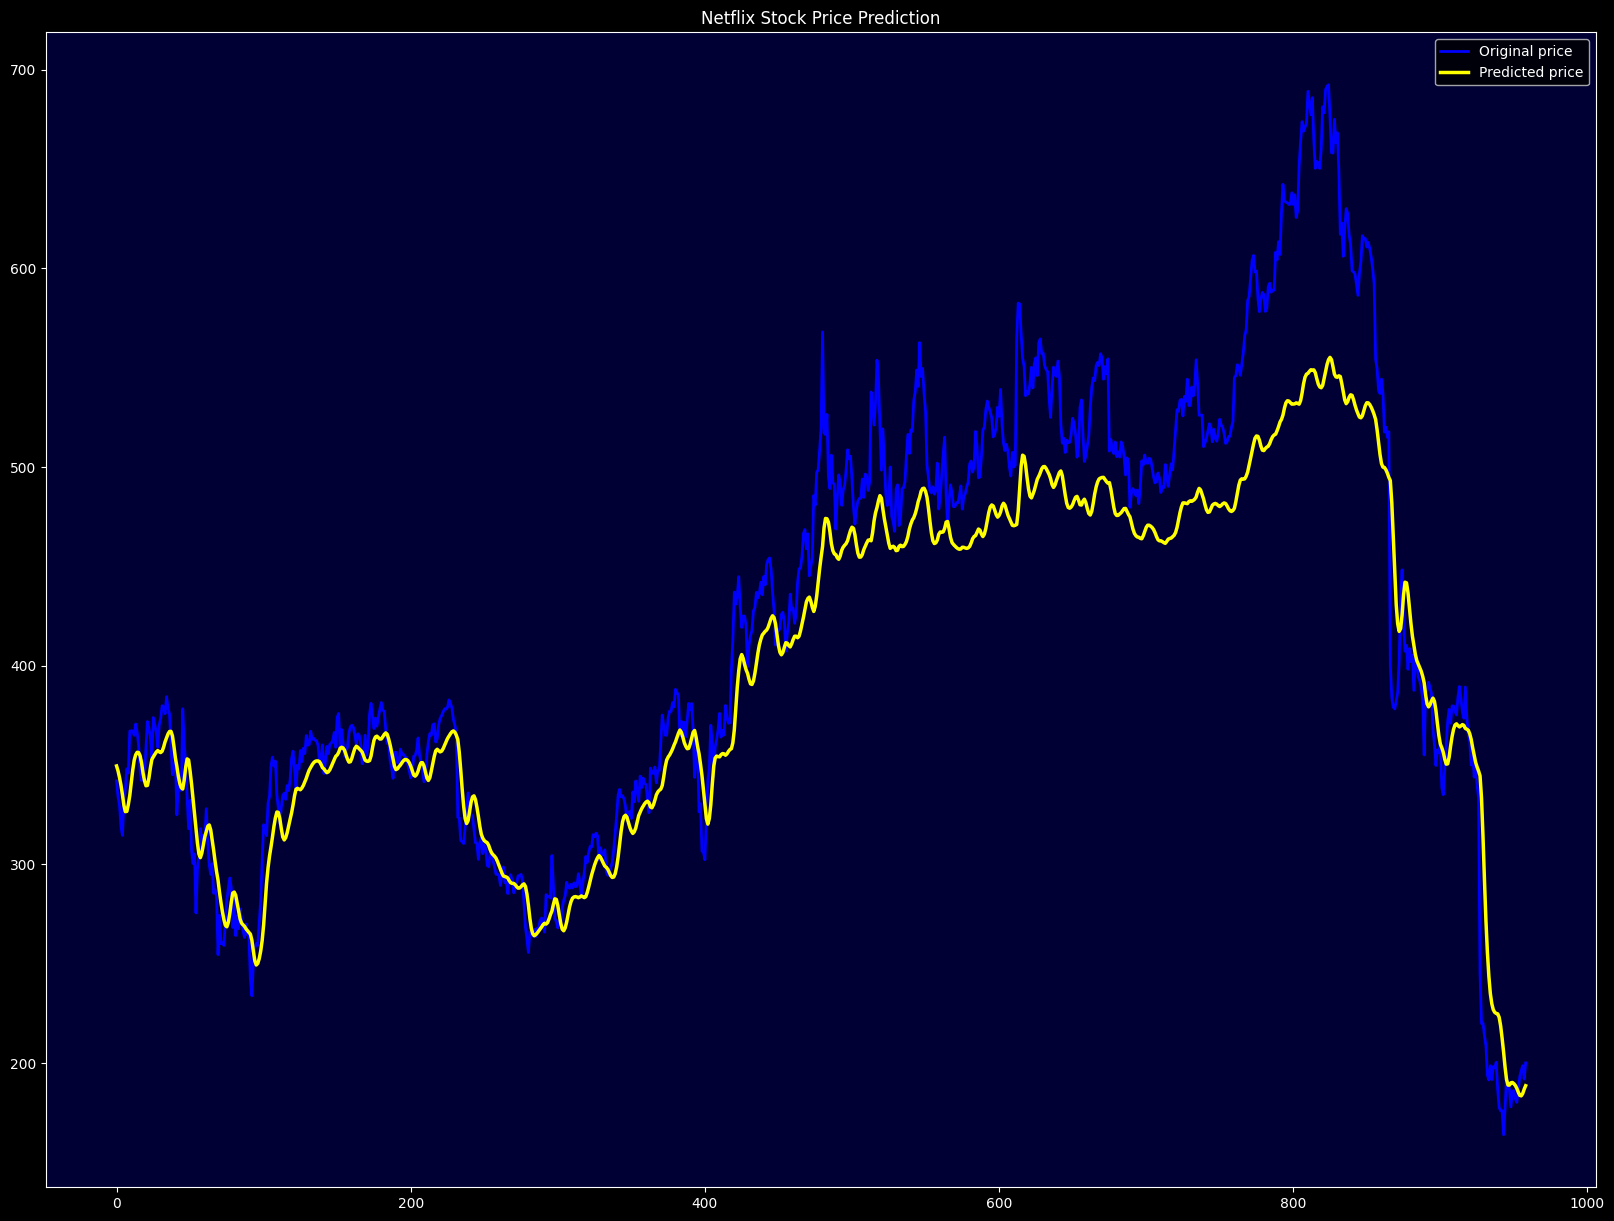

In [23]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(20,15))
ax.set_facecolor('#000035')
ax.plot(y_test_scaled, color='blue', linewidth=2, label='Original price')
plt.plot(predictions, color='yellow', linewidth=2.5, label='Predicted price')
plt.title('Netflix Stock Price Prediction')
plt.legend();

# Thankyou

## Presented by : Monika Maheshwari